# **Hands-on**
Reconhecimento de atividades humanas

Esse tutorial tem como objetivo desenvolver um código para realizar o reconhecimento de atividades humanas (Human Activity Recognition - HAR) usando redes neurais convolucionais e o framework TensorFlow.


## Dataset

Dataset que inclui dados de **séries temporais gerados por sensores de acelerômetro e giroscópio** (atitude, gravidade, userAcceleration e rotationRate). 

Coletado com um iPhone 6s mantido no bolso frontal do participante usando o **SensingKit**, que coleta informações da estrutura Core Motion em dispositivos iOS. Todos os dados coletados em taxa de **amostragem de 50Hz**. 

Um total de **24 participantes** em uma faixa de gênero, idade, peso e altura realizaram **6 atividades em 15 tentativas** no mesmo ambiente e condições: subir escada, descer escada, caminhar, correr, sentar e ficar em pé. 

Proposta de **inferir gênero ou personalidade dos titulares dos dados**, **além de suas atividades.**


---

Foram coletados informações como idade, sexo, altura e peso e utilizado um smartphone (iPhone 6) armazenado no bolso da frente da calça durante o experimento. Todos os participantes foram convidados a usar sapatos baixos.

Os participantes realizaram 6 atividades diferentes (descer as escadas, subir as escadas, sentar, ficar de pé e correr) ao redor do campus **Queen Mary University of London's Mile End**. 

O participante é reponsavel por apertar o botão iniciar do aplicativo **Crowdsense**, para iniciar o experimento, realizando da forma mais natural possível, como no dia a dia. No final de cada tentativa apertavam o botão de parar. Os locais e rotas exatos para execução de todas as atividades são mostrados no mapa ilustrativo da Figura a seguir.


<img src="https://github.com/mmalekzadeh/motion-sense/raw/master/materials/e_map.png"></img>

**Kaggle:** https://www.kaggle.com/malekzadeh/motionsense-dataset

**Github:** https://github.com/mmalekzadeh/motion-sense

**Github Deep:** https://github.com/mmalekzadeh/dana


# Aquisição dos Dados (Dataset)

In [ ]:
#from urllib.request import urlretrieve
import os 
url = "https://github.com/mmalekzadeh/motion-sense/blob/261cb0d60611a049ab38127738e42cc510ed50f4/data/A_DeviceMotion_data.zip"
if(os.path.isdir("/content/A_DeviceMotion_data")):
  print("o diretorio já foi criado")
else:
  !git clone https://github.com/mmalekzadeh/motion-sense.git
  !unzip /content/motion-sense/data/A_DeviceMotion_data.zip

Cloning into 'motion-sense'...
remote: Enumerating objects: 612, done.
remote: Counting objects: 100% (34/34), done.
remote: Compressing objects: 100% (30/30), done.
remote: Total 612 (delta 14), reused 15 (delta 4), pack-reused 578
Receiving objects: 100% (612/612), 201.78 MiB | 11.93 MiB/s, done.
Resolving deltas: 100% (289/289), done.
Checking out files: 100% (74/74), done.
Archive:  /content/motion-sense/data/A_DeviceMotion_data.zip
   creating: A_DeviceMotion_data/
   creating: A_DeviceMotion_data/dws_11/
  inflating: A_DeviceMotion_data/dws_11/sub_12.csv  
  inflating: A_DeviceMotion_data/dws_11/sub_1.csv  
  inflating: A_DeviceMotion_data/dws_11/sub_13.csv  
  inflating: A_DeviceMotion_data/dws_11/sub_11.csv  
  inflating: A_DeviceMotion_data/dws_11/sub_2.csv  
  inflating: A_DeviceMotion_data/dws_11/sub_3.csv  
  inflating: A_DeviceMotion_data/dws_11/sub_10.csv  
  inflating: A_DeviceMotion_data/dws_11/sub_14.csv  
  inflating: A_DeviceMotion_data/dws_11/sub_7.csv  
  inflating

# Pré-processamento de dados (Pandas / Numpy)

In [ ]:
import numpy as np 

In [ ]:
import pandas as pd

In [ ]:
def get_ds_infos():
    """
    Read the file includes data subject information.
    
    Data Columns:
    0: code [1-24]
    1: weight [kg]
    2: height [cm]
    3: age [years]
    4: gender [0:Female, 1:Male]
    
    Returns:
        A pandas DataFrame that contains inforamtion about data subjects' attributes 
    """ 

    dss = pd.read_csv("/content/motion-sense/data/data_subjects_info.csv")
    print("[INFO] -- Data subjects' information is imported.")
    
    return dss

def set_data_types(data_types=["userAcceleration"]):
    """
    Select the sensors and the mode to shape the final dataset.
    
    Args:
        data_types: A list of sensor data type from this list: [attitude, gravity, rotationRate, userAcceleration] 

    Returns:
        It returns a list of columns to use for creating time-series from files.
    """
    dt_list = []
    for t in data_types:
        if t != "attitude":
            dt_list.append([t+".x",t+".y",t+".z"])
        else:
            dt_list.append([t+".roll", t+".pitch", t+".yaw"])

    return dt_list


def creat_time_series(dt_list, act_labels, trial_codes, mode="mag", labeled=True):
    """
    Args:
        dt_list: A list of columns that shows the type of data we want.
        act_labels: list of activites
        trial_codes: list of trials
        mode: It can be "raw" which means you want raw data
        for every dimention of each data type,
        [attitude(roll, pitch, yaw); gravity(x, y, z); rotationRate(x, y, z); userAcceleration(x,y,z)].
        or it can be "mag" which means you only want the magnitude for each data type: (x^2+y^2+z^2)^(1/2)
        labeled: True, if we want a labeld dataset. False, if we only want sensor values.

    Returns:
        It returns a time-series of sensor data.
    
    """
    num_data_cols = len(dt_list) if mode == "mag" else len(dt_list*3)

    if labeled:
        dataset = np.zeros((0,num_data_cols+7)) # "7" --> [act, code, weight, height, age, gender, trial] 
    else:
        dataset = np.zeros((0,num_data_cols))
        
    ds_list = get_ds_infos()
    
    print("[INFO] -- Creating Time-Series")
    for sub_id in ds_list["code"]:
        for act_id, act in enumerate(act_labels):
            for trial in trial_codes[act_id]:
                fname = 'A_DeviceMotion_data/'+act+'_'+str(trial)+'/sub_'+str(int(sub_id))+'.csv'
                raw_data = pd.read_csv(fname)
                raw_data = raw_data.drop(['Unnamed: 0'], axis=1)
                vals = np.zeros((len(raw_data), num_data_cols))
                for x_id, axes in enumerate(dt_list):
                    if mode == "mag":
                        vals[:,x_id] = (raw_data[axes]**2).sum(axis=1)**0.5        
                    else:
                        vals[:,x_id*3:(x_id+1)*3] = raw_data[axes].values
                    vals = vals[:,:num_data_cols]
                if labeled:
                    lbls = np.array([[act_id,
                            sub_id-1,
                            ds_list["weight"][sub_id-1],
                            ds_list["height"][sub_id-1],
                            ds_list["age"][sub_id-1],
                            ds_list["gender"][sub_id-1],
                            trial          
                           ]]*len(raw_data))
                    vals = np.concatenate((vals, lbls), axis=1)
                dataset = np.append(dataset,vals, axis=0)
    cols = []
    for axes in dt_list:
        if mode == "raw":
            cols += axes
        else:
            cols += [str(axes[0][:-2])]
            
    if labeled:
        cols += ["act", "id", "weight", "height", "age", "gender", "trial"]
    
    dataset = pd.DataFrame(data=dataset, columns=cols)
    return dataset
#________________________________


ACT_LABELS = ["dws","ups", "wlk", "jog", "std", "sit"]
TRIAL_CODES = {
    ACT_LABELS[0]:[1,2,11],
    ACT_LABELS[1]:[3,4,12],
    ACT_LABELS[2]:[7,8,15],
    ACT_LABELS[3]:[9,16],
    ACT_LABELS[4]:[6,14],
    ACT_LABELS[5]:[5,13]
}


## Here we set parameter to build labeld time-series from dataset of "(A)DeviceMotion_data"
## attitude(roll, pitch, yaw); gravity(x, y, z); rotationRate(x, y, z); userAcceleration(x,y,z)
sdt = ["attitude", "userAcceleration", "gravity", "rotationRate"]
print("[INFO] -- Selected sensor data types: "+str(sdt))    
act_labels = ACT_LABELS# [0:4]
print("[INFO] -- Selected activites: "+str(act_labels))    
trial_codes = [TRIAL_CODES[act] for act in act_labels]
dt_list = set_data_types(sdt)
dataset = creat_time_series(dt_list, act_labels, trial_codes, mode="raw", labeled=True)
print("[INFO] -- Shape of time-Series dataset:"+str(dataset.shape))    


[INFO] -- Selected sensor data types: ['attitude', 'userAcceleration', 'gravity', 'rotationRate']
[INFO] -- Selected activites: ['dws', 'ups', 'wlk', 'jog', 'std', 'sit']
[INFO] -- Data subjects' information is imported.
[INFO] -- Creating Time-Series
[INFO] -- Shape of time-Series dataset:(1412865, 19)


## Nomalização / Padronização

A **Padronização** de conjuntos de dados é um requisito comum para muitos estimadores de aprendizado de máquina.

In [ ]:
features_1 = list(dataset.columns)

# separating features from other data
features_1.remove('act')
features_1.remove('id')
features_1.remove('trial')
features_1.remove('height')
features_1.remove('age')
features_1.remove('gender')
features_1.remove('weight')

dataset[features_1].head()

,attitude.roll,attitude.pitch,attitude.yaw,userAcceleration.x,userAcceleration.y,userAcceleration.z,gravity.x,gravity.y,gravity.z,rotationRate.x,rotationRate.y,rotationRate.z
0,1.528132,-0.733896,0.696372,0.294894,-0.184493,0.377542,0.741895,0.669768,-0.031672,0.316738,0.778180,1.082764
1,1.527992,-0.716987,0.677762,0.219405,0.035846,0.114866,0.753099,0.657116,-0.032255,0.842032,0.424446,0.643574
2,1.527765,-0.706999,0.670951,0.010714,0.134701,-0.167808,0.759611,0.649555,-0.032707,-0.138143,-0.040741,0.343563
3,1.516768,-0.704678,0.675735,-0.008389,0.136788,0.094958,0.760709,0.647788,-0.041140,-0.025005,-1.048717,0.035860
4,1.493941,-0.703918,0.672994,0.199441,0.353996,-0.044299,0.760062,0.647210,-0.058530,0.114253,-0.912890,0.047341


In [ ]:
from sklearn import preprocessing

ss_scale= preprocessing.StandardScaler().fit(dataset[features_1])
X_ss_scale = ss_scale.transform(dataset[features_1])

In [ ]:
df_standard = pd.DataFrame(data=X_ss_scale,index=dataset.index,columns=features_1)
df_standard.head()

,attitude.roll,attitude.pitch,attitude.yaw,userAcceleration.x,userAcceleration.y,userAcceleration.z,gravity.x,gravity.y,gravity.z,rotationRate.x,rotationRate.y,rotationRate.z
0,1.087782,0.511556,0.547422,0.910410,-0.433570,0.899148,2.065229,-0.254915,0.250168,0.240864,0.622599,1.324195
1,1.087692,0.545779,0.535375,0.680407,-0.015918,0.200935,2.098296,-0.292879,0.248807,0.647150,0.334183,0.780671
2,1.087547,0.565994,0.530966,0.044559,0.171461,-0.550434,2.117515,-0.315567,0.247752,-0.110962,-0.045107,0.409389
3,1.080528,0.570692,0.534063,-0.013645,0.175417,0.148018,2.120756,-0.320869,0.228063,-0.023456,-0.866958,0.028587
4,1.065957,0.572230,0.532289,0.619580,0.587134,-0.222137,2.118846,-0.322603,0.187463,0.084253,-0.756212,0.042796


In [ ]:
# Transforming the 'act' column into binary columns [dws, 	ups, 	wlk, 	jog, 	std, 	sit]
for i in range(len(ACT_LABELS)):
  lista = np.where(dataset['act'] == i, 1, 0)
  df_standard[ACT_LABELS[i]] = np.array(lista)
df_standard.head()  

,attitude.roll,attitude.pitch,attitude.yaw,userAcceleration.x,userAcceleration.y,userAcceleration.z,gravity.x,gravity.y,gravity.z,rotationRate.x,rotationRate.y,rotationRate.z,dws,ups,wlk,jog,std,sit
0,1.087782,0.511556,0.547422,0.910410,-0.433570,0.899148,2.065229,-0.254915,0.250168,0.240864,0.622599,1.324195,1,0,0,0,0,0
1,1.087692,0.545779,0.535375,0.680407,-0.015918,0.200935,2.098296,-0.292879,0.248807,0.647150,0.334183,0.780671,1,0,0,0,0,0
2,1.087547,0.565994,0.530966,0.044559,0.171461,-0.550434,2.117515,-0.315567,0.247752,-0.110962,-0.045107,0.409389,1,0,0,0,0,0
3,1.080528,0.570692,0.534063,-0.013645,0.175417,0.148018,2.120756,-0.320869,0.228063,-0.023456,-0.866958,0.028587,1,0,0,0,0,0
4,1.065957,0.572230,0.532289,0.619580,0.587134,-0.222137,2.118846,-0.322603,0.187463,0.084253,-0.756212,0.042796,1,0,0,0,0,0


## Normalização 

A **Normalização** é o processo de dimensionar amostras individuais para ter norma unitária . 

Normas l1, l2, ou max

In [ ]:
nor_df = preprocessing.normalize(dataset[features_1],norm='l2')

In [ ]:
normalized_df = pd.DataFrame(data=nor_df,index=dataset.index,columns=features_1)
normalized_df.head()

,attitude.roll,attitude.pitch,attitude.yaw,userAcceleration.x,userAcceleration.y,userAcceleration.z,gravity.x,gravity.y,gravity.z,rotationRate.x,rotationRate.y,rotationRate.z
0,0.599358,-0.287846,0.273128,0.115662,-0.072361,0.148078,0.290983,0.262694,-0.012422,0.124230,0.305215,0.424678
1,0.641461,-0.300996,0.284529,0.092108,0.015048,0.048221,0.316156,0.275861,-0.013541,0.353490,0.178185,0.270176
2,0.722666,-0.334426,0.317374,0.005068,0.063716,-0.079377,0.359312,0.307253,-0.015471,-0.065345,-0.019271,0.162513
3,0.653725,-0.303715,0.291241,-0.003616,0.058955,0.040927,0.327865,0.279196,-0.017731,-0.010777,-0.451996,0.015456
4,0.655389,-0.308807,0.295241,0.087494,0.155297,-0.019434,0.333438,0.283930,-0.025677,0.050123,-0.400483,0.020768


In [ ]:
# Transforming the 'act' column into binary columns [dws, 	ups, 	wlk, 	jog, 	std, 	sit]

for i in range(len(ACT_LABELS)):
  lista = np.where(dataset['act'] == i, 1, 0)
  normalized_df[ACT_LABELS[i]] = np.array(lista)
normalized_df.head()  

,attitude.roll,attitude.pitch,attitude.yaw,userAcceleration.x,userAcceleration.y,userAcceleration.z,gravity.x,gravity.y,gravity.z,rotationRate.x,rotationRate.y,rotationRate.z,dws,ups,wlk,jog,std,sit
0,0.599358,-0.287846,0.273128,0.115662,-0.072361,0.148078,0.290983,0.262694,-0.012422,0.124230,0.305215,0.424678,1,0,0,0,0,0
1,0.641461,-0.300996,0.284529,0.092108,0.015048,0.048221,0.316156,0.275861,-0.013541,0.353490,0.178185,0.270176,1,0,0,0,0,0
2,0.722666,-0.334426,0.317374,0.005068,0.063716,-0.079377,0.359312,0.307253,-0.015471,-0.065345,-0.019271,0.162513,1,0,0,0,0,0
3,0.653725,-0.303715,0.291241,-0.003616,0.058955,0.040927,0.327865,0.279196,-0.017731,-0.010777,-0.451996,0.015456,1,0,0,0,0,0
4,0.655389,-0.308807,0.295241,0.087494,0.155297,-0.019434,0.333438,0.283930,-0.025677,0.050123,-0.400483,0.020768,1,0,0,0,0,0


# Aprendizado Centralizado

Considerando os dados do MotionSense, se identificarmos as atividades que o usuário está exercendo baseado nos dados de sensores, temos um problema multi-classe, uma vez que só pode exercer uma atividade por vez (classes mutuamente exclusivas). As classes são:

In [ ]:
ACT_LABELS

['dws', 'ups', 'wlk', 'jog', 'std', 'sit']

Para o desenvolvimento do nosso código de redes neurais, nós utilizamos a API de aprendizado profundo Keras. Essa ferramenta é executada na plataforma de aprendizado de máquina TensorFlow, que é uma plataforma de machine learning de código aberto.

In [ ]:
from keras.models import Sequential
from keras.layers import Dense
import keras

n_features = len(features_1)

# Desired output
Y = normalized_df[ACT_LABELS]

def baseline_model(n_inputs=n_features, len_last_layer=len(ACT_LABELS)):
  
  # Sequential: linear stack of layers.
  model=Sequential()

  # Units: number of neurons, uniform kernel_initializer: The initializer generates weights with uniform distribution. 
  # The activation function limits the output within a range of values.
  model.add(Dense(units=64, kernel_initializer='uniform', activation='relu', input_dim=n_inputs)) 
  model.add(Dense(units=128, kernel_initializer='uniform', activation='relu'))
  model.add(Dense(units=64, kernel_initializer='uniform', activation='relu')) 
  
  # The units of the last layer are the number of classes
  # First 3 layers using the relu function and the last layer using softmax activation function for multi-classe problems.
  model.add(Dense(units=len_last_layer, kernel_initializer='uniform', activation='softmax'))
  
  # Categorical_crossentropy (cce) produces a one-hot array containing the probable match for each category  
  model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
  # Adam: https://towardsdatascience.com/adam-optimization-algorithm-1cdc9b12724a
  
  return model

In [ ]:
from sklearn.model_selection import train_test_split

# Data without standardization and normalization
X = dataset[features_1]

# Getting the training and testing input and output data
X_train, X_test, y_train, y_test = train_test_split(X, Y, shuffle=True)

# Creating the model
model = baseline_model()

# The batch size defines the number of samples that will be propagated through the network.
# An epoch is an iteration over all given x and y data.
history_1 = model.fit(X_train, y_train, batch_size=200, epochs=20, validation_data=(X_test,y_test)) 

Epoch 1/20
5299/5299 [==============================] - 27s 5ms/step - loss: 0.5434 - accuracy: 0.7848 - val_loss: 0.4644 - val_accuracy: 0.8211
Epoch 2/20
5299/5299 [==============================] - 23s 4ms/step - loss: 0.4450 - accuracy: 0.8305 - val_loss: 0.4209 - val_accuracy: 0.8408
Epoch 3/20
5299/5299 [==============================] - 23s 4ms/step - loss: 0.4091 - accuracy: 0.8459 - val_loss: 0.3985 - val_accuracy: 0.8515
Epoch 4/20
5299/5299 [==============================] - 23s 4ms/step - loss: 0.3855 - accuracy: 0.8563 - val_loss: 0.3779 - val_accuracy: 0.8589
Epoch 5/20
5299/5299 [==============================] - 23s 4ms/step - loss: 0.3690 - accuracy: 0.8629 - val_loss: 0.3641 - val_accuracy: 0.8650
Epoch 6/20
5299/5299 [==============================] - 24s 5ms/step - loss: 0.3565 - accuracy: 0.8682 - val_loss: 0.3569 - val_accuracy: 0.8686
Epoch 7/20
5299/5299 [==============================] - 23s 4ms/step - loss: 0.3466 - accuracy: 0.8723 - val_loss: 0.3463 - val_ac

11039/11039 - 32s - loss: 0.2957 - accuracy: 0.8935 - 32s/epoch - 3ms/step
Test loss: 0.29571717977523804
Test accuracy: 0.8935158848762512


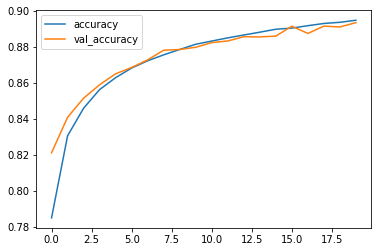

In [ ]:
test_scores = model.evaluate(X_test, y_test, verbose=2)
print("Test loss:", test_scores[0])
print("Test accuracy:", test_scores[1])
history_df = pd.DataFrame(history_1.history)
history_df.loc[:, ['accuracy', 'val_accuracy']].plot()

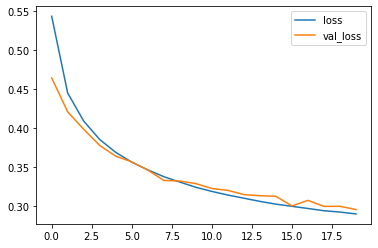

In [ ]:
history_df.loc[:, ['loss', 'val_loss']].plot()
plt.show()

A função create_lag_features obtém informações de pontos consecutivos no tempo em uma linha. Cada linha contém dados sobre uma observação e inclui todas as ocorrências anteriores dessa observação, visto que temos uma série temporal. Para conseguir isso, utiliza-se recursos de atraso para copiar um recurso em uma nova coluna e deslocá-lo uma ou mais linhas para baixo. Dependendo da quantidade X de recursos de atraso, o dataframe obtém X colunas adicionais com X deslocamentos no tempo.


In [ ]:
def create_lag_features(n, cols, df, y):
    """

    Parameters
    ----------
    n : int
        amount of lag features
    cols : list
        list of columns to lag
    df: pd.DataFrame
        data
    y: pd.DataFrame
        output data

    Returns
    -------
    pd.DataFrame
        a dataframe with the list of columns lagged n times

    """

    lag_features = n
    lag_df = df.copy()
    lag_Y = y
    for j in cols:
        for i in range(lag_features):
            lag_df.insert(7+i, j + '_lag' + str(i+1), lag_df[j].shift(i+1))
        
    # Dropping all rows where the lag overlapped two different subjects/trials (n timeframes at the beginning of every trial).

    for i in range(lag_features):
        lag_df = lag_df.drop([i])
        lag_Y = lag_Y.drop([i])
    return lag_df, lag_Y

In [ ]:
X = dataset[features_1]

# Adding 50 columns related to rotationRate feature
lag_df, lag_Y = create_lag_features(50, ['rotationRate.x'], X, Y)
lag_df.head()

,attitude.roll,attitude.pitch,attitude.yaw,userAcceleration.x,userAcceleration.y,userAcceleration.z,gravity.x,rotationRate.x_lag1,rotationRate.x_lag2,rotationRate.x_lag3,...,rotationRate.x_lag46,rotationRate.x_lag47,rotationRate.x_lag48,rotationRate.x_lag49,rotationRate.x_lag50,gravity.y,gravity.z,rotationRate.x,rotationRate.y,rotationRate.z
50,1.583899,-0.805282,0.946705,0.040367,-0.299029,-0.045944,0.692848,-0.304708,-0.333441,-0.525354,...,0.114253,-0.025005,-0.138143,0.842032,0.316738,0.721026,0.009079,-0.119064,-0.926548,-0.050391
51,1.565382,-0.806011,0.949998,-0.029408,-0.257832,0.071864,0.692372,-0.119064,-0.304708,-0.333441,...,0.187742,0.114253,-0.025005,-0.138143,0.842032,0.721531,-0.003749,-0.140231,-1.085363,-0.009743
52,1.548804,-0.804420,0.956486,-0.072603,-0.215256,0.043220,0.693361,-0.140231,-0.119064,-0.304708,...,0.343096,0.187742,0.114253,-0.025005,-0.138143,0.720429,-0.015251,-0.276480,-1.122698,0.120744
53,1.522246,-0.801376,0.962008,-0.119017,-0.269660,-0.007145,0.694899,-0.276480,-0.140231,-0.119064,...,0.176202,0.343096,0.187742,0.114253,-0.025005,0.718314,-0.033764,-0.062344,-1.807737,0.218189
54,1.478320,-0.794111,0.960570,-0.141436,-0.268768,-0.034777,0.697924,-0.062344,-0.276480,-0.140231,...,0.274786,0.176202,0.343096,0.187742,0.114253,0.713241,-0.064726,0.122015,-2.354657,0.432754


In [ ]:
from keras.callbacks import EarlyStopping

# the early_stopping callback function was implemented to increase the amount of epochs without worrying about overfitting
early_stopping = EarlyStopping(min_delta=0.001, patience=10, restore_best_weights=True)

In [ ]:
# applying function create_lag_features on data without standardization and normalization
X_train, X_test, y_train, y_test = train_test_split(lag_df, lag_Y, shuffle=True)
model_1 = baseline_model(n_inputs=lag_df.shape[1])


history_1 = model_1.fit(X_train, y_train, batch_size=200, epochs=20, validation_data=(X_test,y_test), callbacks=[early_stopping])

Epoch 1/20
5299/5299 [==============================] - 20s 4ms/step - loss: 0.2789 - accuracy: 0.9062 - val_loss: 0.1884 - val_accuracy: 0.9403
Epoch 2/20
5299/5299 [==============================] - 20s 4ms/step - loss: 0.1674 - accuracy: 0.9477 - val_loss: 0.1516 - val_accuracy: 0.9530
Epoch 3/20
5299/5299 [==============================] - 19s 4ms/step - loss: 0.1398 - accuracy: 0.9568 - val_loss: 0.1410 - val_accuracy: 0.9558
Epoch 4/20
5299/5299 [==============================] - 20s 4ms/step - loss: 0.1227 - accuracy: 0.9618 - val_loss: 0.1178 - val_accuracy: 0.9638
Epoch 5/20
5299/5299 [==============================] - 19s 4ms/step - loss: 0.1114 - accuracy: 0.9651 - val_loss: 0.1132 - val_accuracy: 0.9646
Epoch 6/20
5299/5299 [==============================] - 19s 4ms/step - loss: 0.1032 - accuracy: 0.9674 - val_loss: 0.1044 - val_accuracy: 0.9668
Epoch 7/20
5299/5299 [==============================] - 19s 4ms/step - loss: 0.0972 - accuracy: 0.9690 - val_loss: 0.0969 - val_ac

11038/11038 - 19s - loss: 0.0782 - accuracy: 0.9745 - 19s/epoch - 2ms/step
Test loss: 0.07816322147846222
Test accuracy: 0.9744849801063538


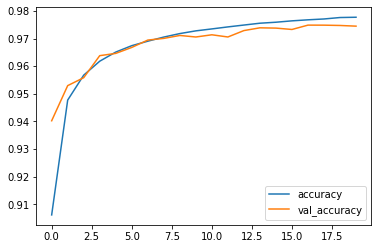

In [ ]:
test_scores = model_1.evaluate(X_test, y_test, verbose=2)
print("Test loss:", test_scores[0])
print("Test accuracy:", test_scores[1])
history_df = pd.DataFrame(history_1.history)
history_df.loc[:, ['accuracy', 'val_accuracy']].plot()

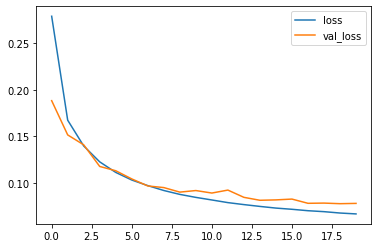

In [ ]:
history_df.loc[:, ['loss', 'val_loss']].plot()
plt.show()

In [ ]:
# normalized data
X_n = nor_df[features_1]

# Adding 50 columns related to rotationRate feature
lag_df_n, lag_Y_n = create_lag_features(50, ['rotationRate.x'], X_n, Y)
X_train_n, X_test_n, y_train_n, y_test_n = train_test_split(lag_df_n, lag_Y_n, shuffle=True)

model_n = baseline_model(n_inputs=lag_df_n.shape[1])
history = model_n.fit(X_train_n, y_train_n, batch_size=200, epochs=20, validation_data=(X_test_n,y_test_n), callbacks=[early_stopping])

Epoch 1/20
5299/5299 [==============================] - 24s 4ms/step - loss: 0.3275 - accuracy: 0.8847 - val_loss: 0.2233 - val_accuracy: 0.9268
Epoch 2/20
5299/5299 [==============================] - 23s 4ms/step - loss: 0.1979 - accuracy: 0.9366 - val_loss: 0.1803 - val_accuracy: 0.9430
Epoch 3/20
5299/5299 [==============================] - 24s 5ms/step - loss: 0.1649 - accuracy: 0.9477 - val_loss: 0.1537 - val_accuracy: 0.9514
Epoch 4/20
5299/5299 [==============================] - 26s 5ms/step - loss: 0.1465 - accuracy: 0.9538 - val_loss: 0.1440 - val_accuracy: 0.9539
Epoch 5/20
5299/5299 [==============================] - 24s 5ms/step - loss: 0.1342 - accuracy: 0.9577 - val_loss: 0.1306 - val_accuracy: 0.9594
Epoch 6/20
5299/5299 [==============================] - 24s 5ms/step - loss: 0.1260 - accuracy: 0.9602 - val_loss: 0.1234 - val_accuracy: 0.9607
Epoch 7/20
5299/5299 [==============================] - 23s 4ms/step - loss: 0.1190 - accuracy: 0.9627 - val_loss: 0.1186 - val_ac

11038/11038 - 25s - loss: 0.0902 - accuracy: 0.9715 - 25s/epoch - 2ms/step
Test loss: 0.09018150717020035
Test accuracy: 0.9715433716773987


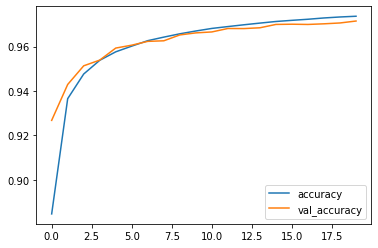

In [ ]:
test_scores = model_n.evaluate(X_test_n, y_test_n, verbose=2)
print("Test loss:", test_scores[0])
print("Test accuracy:", test_scores[1])
history_df = pd.DataFrame(history.history)
history_df.loc[:, ['accuracy', 'val_accuracy']].plot()

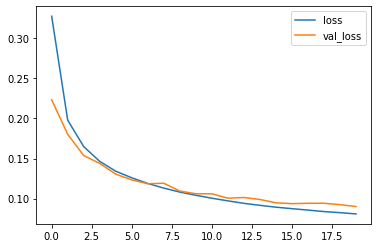

In [ ]:
history_df.loc[:, ['loss', 'val_loss']].plot()
plt.show()

In [ ]:
# Standardized data
X_p = ss_df[features_1]

# Adding 50 columns related to rotationRate feature
lag_df_p, lag_Y_p = create_lag_features(50, ['rotationRate.x'], X_p, Y)

# no shuffered data
X_train_p, X_test_p, y_train_p, y_test_p = train_test_split(lag_df_p, lag_Y_p, shuffle=False)
model_p = baseline_model(n_inputs=X_train_p.shape[1])
history = model_p.fit(X_train_p, y_train_p, batch_size=200, epochs=20, validation_data=(X_test_p,y_test_p), callbacks=[early_stopping])

Epoch 1/20
5299/5299 [==============================] - 24s 4ms/step - loss: 0.2535 - accuracy: 0.9169 - val_loss: 0.3491 - val_accuracy: 0.8810
Epoch 2/20
5299/5299 [==============================] - 23s 4ms/step - loss: 0.1460 - accuracy: 0.9547 - val_loss: 0.3364 - val_accuracy: 0.8889
Epoch 3/20
5299/5299 [==============================] - 24s 4ms/step - loss: 0.1213 - accuracy: 0.9618 - val_loss: 0.3779 - val_accuracy: 0.8850
Epoch 4/20
5299/5299 [==============================] - 23s 4ms/step - loss: 0.1071 - accuracy: 0.9659 - val_loss: 0.3613 - val_accuracy: 0.8868
Epoch 5/20
5299/5299 [==============================] - 23s 4ms/step - loss: 0.0975 - accuracy: 0.9686 - val_loss: 0.4288 - val_accuracy: 0.8767
Epoch 6/20
5299/5299 [==============================] - 24s 5ms/step - loss: 0.0899 - accuracy: 0.9706 - val_loss: 0.4512 - val_accuracy: 0.8724
Epoch 7/20
5299/5299 [==============================] - 23s 4ms/step - loss: 0.0839 - accuracy: 0.9723 - val_loss: 0.4851 - val_ac

11038/11038 - 29s - loss: 0.3364 - accuracy: 0.8889 - 29s/epoch - 3ms/step
Test loss: 0.3364179730415344
Test accuracy: 0.8889366984367371


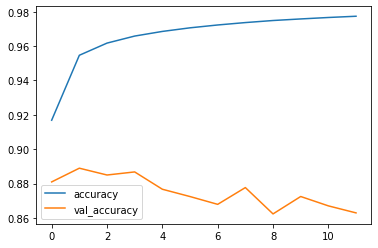

In [ ]:
test_scores = model_p.evaluate(X_test_p, y_test_p, verbose=2)
print("Test loss:", test_scores[0])
print("Test accuracy:", test_scores[1])
history_df = pd.DataFrame(history.history)
history_df.loc[:, ['accuracy', 'val_accuracy']].plot()

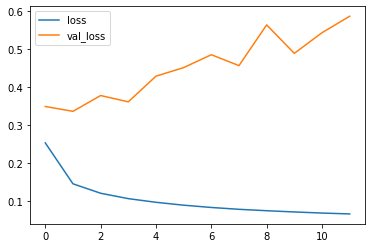

In [ ]:
history_df.loc[:, ['loss', 'val_loss']].plot()
plt.show()